<a href="https://colab.research.google.com/github/susandong/w266_final_project_game_sentiment/blob/master/w266_Final_Project_Game_Review_Sentiment_Analysis_Aspect_Extraction_1116.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project: Game Review Sentiment Analysis Aspect Extraction

* Can we use sentiment analysis score to predict the active user base for video games over time

## Dataset: 
* Game Review: twitter/reddit/discord/steam reviews
* active user base: steam

## Algorithm: 
* Baseline(logistic Regression); 
* Transformer(Elmo/Bert)


In [2]:
#Load libraries
import pandas as pd
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
""" Download Data: There are 4 games with review data
Fall Guys (fg)
PlayerUnknown Battlegrounds (pubg)
Dota 2 (dota2)
Counterstrike Source: Go (csgo)

Review data has the following columns:
app: ID for the game
useful: how many users voted the review as useful
funny: how many users voted the review as funny
username: username of the person who wrote the review
games_owned: how many games the reviewer owns on Steam
num_reviews: how many reviews the reviewer has written on Steam
recommend: 1 for recommend (thumbs up), -1 for do not recommend (thumbs down)
hours_played: number of hours the reviewer played before writing the review
date: date review was written
text: text of the review
"""
#Fall Guys
fg_url = 'https://raw.githubusercontent.com/susandong/w266_final_project_game_sentiment/master/data/fallguys_reviews.csv'
fg_df = pd.read_csv(fg_url, error_bad_lines=False)
fg_df = fg_df.dropna()

#CS: Go
csgo_url = 'https://raw.githubusercontent.com/susandong/w266_final_project_game_sentiment/master/data/csgo_reviews.csv'
csgo_df = pd.read_csv(csgo_url, error_bad_lines=False)
csgo_df = csgo_df.dropna()

#PUBG
pubg_url = 'https://raw.githubusercontent.com/susandong/w266_final_project_game_sentiment/master/data/pubg_reviews.csv'
pubg_df = pd.read_csv(pubg_url, error_bad_lines=False)
pubg_df = pubg_df.dropna()

#dota2_url = 'https://raw.githubusercontent.com/susandong/w266_final_project_game_sentiment/master/data/dota2_reviews.csv'
#dota2_df = pd.read_csv(dota2_url, error_bad_lines=False)
#player_url = 'https://raw.githubusercontent.com/susandong/w266_final_project_game_sentiment/master/data/PlayerCountData.csv'
#player_df = pd.read_csv(player_url, error_bad_lines=False)

In [4]:
# Data Preprocessing
!pip install unidecode
import unidecode
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
#from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')

tknzr = TweetTokenizer()
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
#lemma = WordNetLemmatizer()

#Convert accented characters
def remove_accents(text):
  try:
    text = unidecode.unidecode(text)
  except:
    pass
  return text

#Remove digits and punctuation
def remove_nonletters(text):
  try:
    #Remove digits AND punctuation
    text = re.sub('[^a-zA-Z]', ' ', text)
    
    #Remove just digits that are by themselves
    #text = re.sub('^\d+\s|\s\d+\s|\s\d+$', ' ', text)
  except:
    pass
  return text


#Use Tweet Tokenizer for some built-in emoji support
def tweet_tokenization(text):
  try:
    return tknzr.tokenize(text)
  except:
    pass

def remove_stopwords(token):
  try:
    return [item for item in token if item not in stop_words]
  except:
    pass

def remove_stemmer(token):
  try:
    return [stemmer.stem(i) for i in token]
  except:
    pass

def remove_lemmatizer(token):
  try:
    return [lemma.lemmatize(word=w, pow='v') for w in token]
  except:
    pass
  
def remove_shortwords(token):
  try:
    return [i for i in token if len(i) > 1]
  except:
    pass

def token_to_string(listTokens):
  return ' '.join(listTokens)

#Process text from dataframe. df = dataframe to clean, text = name of column with text
def process_text(df, text):  
  #Create new column for cleaned text
  df['cleaned'] = df[text]

  #Lower case all text
  df['cleaned'] = df['cleaned'].str.lower()

  #Clean URLs
  df['cleaned'] = df['cleaned'].str.replace('http\S+|www.\S+', '', case=False)

  #Remove accents from text
  #df['cleaned'] = df['cleaned'].apply(remove_accents)

  #Remove numbers and punctuation from text
  df['cleaned'] = df['cleaned'].apply(remove_nonletters)
  
  #Tokenize
  df['cleaned'] = df['cleaned'].apply(tweet_tokenization)

  #Remove stopwords
  #df['cleaned'] = df['cleaned'].apply(remove_stopwords)
  
  #Remove short words
  df['cleaned'] = df['cleaned'].apply(remove_shortwords)

  #Stemming - can decide to use or not
  #df['cleaned'] = df['cleaned'].apply(remove_stemmer)

  #Convert tokens back to string
  df['cleaned'] = df['cleaned'].apply(token_to_string)


     |████████████████████████████████| 245kB 4.3MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
#preprocess all the datasets for all 3 games
process_text(fg_df, 'text')
#len(fg_df['cleaned'][11]) < 2
process_text(csgo_df, 'text')
process_text(pubg_df, 'text')

In [6]:
from nltk.tokenize import RegexpTokenizer
def remove_blankrow(df,column):
  tokenizer = RegexpTokenizer(r'\w+')
  df['lens'] =[len(tokenizer.tokenize(utterance)) for utterance in df[column]]
  df_clean=df[df['lens'] !=0]
  return df_clean

In [7]:
#remove emoji 
def remove_emoji(df,column):
    df[column] = df[column].str.replace(r'[^\x00-\x7F]+', '')
    return df


In [8]:
#from google.colab import drive
#drive.mount('drive')
fg_df_text=remove_blankrow(fg_df,'cleaned')["cleaned"]

csgo_df_text=remove_blankrow(csgo_df,'cleaned')["cleaned"]
pubg_df_text=remove_blankrow(pubg_df,'cleaned')["cleaned"]
pubg_df_text.shape


(226783,)

In [9]:
## Aspect extraction EMbedding_gensim

In [10]:


%matplotlib inline

import nltk.data;

from gensim.models import word2vec;

from sklearn.cluster import KMeans;
from sklearn.neighbors import KDTree;

import pandas as pd;
import numpy as np;

import os;
import re;
import logging;
import sqlite3;
import time;
import sys;
import multiprocessing;
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt;
from itertools import cycle;



In [11]:

nltk.download('punkt')
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle');



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [12]:
#tokenize text
fg_df_text_tokenized=fg_df_text.apply(tweet_tokenization)

In [13]:
start = time.time();

#Set the logging format to get some basic updates.
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 100;    # Dimensionality of the hidden layer representation
min_word_count = 4;   # Minimum word count to keep a word in the vocabulary
num_workers = multiprocessing.cpu_count();       # Number of threads to run in parallel set to total number of cpus.
context = 5          # Context window size (on each side)                                                       
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model. 
#The LineSentence object allows us to pass in a file name directly as input to Word2Vec,
#instead of having to read it into memory first.

print("Training model...");
model = word2vec.Word2Vec(fg_df_text_tokenized, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling);

# We don't plan on training the model any further, so calling 
# init_sims will make the model more memory efficient by normalizing the vectors in-place.
model.init_sims(replace=True);

# Save the model
model_name = "model_full_game";
model.save(model_name);

print('Total time: ' + str((time.time() - start)) + ' secs')

2020-11-29 05:50:00,959 : INFO : collecting all words and their counts
2020-11-29 05:50:00,960 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-11-29 05:50:01,012 : INFO : PROGRESS: at sentence #10000, processed 189986 words, keeping 10008 word types
2020-11-29 05:50:01,056 : INFO : PROGRESS: at sentence #20000, processed 352595 words, keeping 14872 word types
2020-11-29 05:50:01,097 : INFO : PROGRESS: at sentence #30000, processed 501734 words, keeping 18210 word types
2020-11-29 05:50:01,138 : INFO : PROGRESS: at sentence #40000, processed 664869 words, keeping 21477 word types


Training model...


2020-11-29 05:50:01,187 : INFO : PROGRESS: at sentence #50000, processed 850834 words, keeping 24443 word types
2020-11-29 05:50:01,239 : INFO : PROGRESS: at sentence #60000, processed 1059558 words, keeping 27216 word types
2020-11-29 05:50:01,307 : INFO : PROGRESS: at sentence #70000, processed 1344663 words, keeping 30210 word types
2020-11-29 05:50:01,369 : INFO : PROGRESS: at sentence #80000, processed 1603160 words, keeping 33061 word types
2020-11-29 05:50:01,406 : INFO : collected 34952 word types from a corpus of 1748803 raw words and 87847 sentences
2020-11-29 05:50:01,406 : INFO : Loading a fresh vocabulary
2020-11-29 05:50:01,439 : INFO : effective_min_count=4 retains 8887 unique words (25% of original 34952, drops 26065)
2020-11-29 05:50:01,440 : INFO : effective_min_count=4 leaves 1715203 word corpus (98% of original 1748803, drops 33600)
2020-11-29 05:50:01,475 : INFO : deleting the raw counts dictionary of 34952 items
2020-11-29 05:50:01,478 : INFO : sample=0.001 downsa

Total time: 13.350516557693481 secs


In [14]:
model = word2vec.Word2Vec.load('model_full_game')

2020-11-29 05:50:14,320 : INFO : loading Word2Vec object from model_full_game
2020-11-29 05:50:14,396 : INFO : loading wv recursively from model_full_game.wv.* with mmap=None
2020-11-29 05:50:14,397 : INFO : setting ignored attribute vectors_norm to None
2020-11-29 05:50:14,398 : INFO : loading vocabulary recursively from model_full_game.vocabulary.* with mmap=None
2020-11-29 05:50:14,399 : INFO : loading trainables recursively from model_full_game.trainables.* with mmap=None
2020-11-29 05:50:14,400 : INFO : setting ignored attribute cum_table to None
2020-11-29 05:50:14,401 : INFO : loaded model_full_game


In [15]:
model.wv['design']

array([-0.10584325, -0.09538274, -0.05979867,  0.06099617,  0.18323947,
        0.1093502 , -0.08313678,  0.06765286,  0.07784391,  0.12691097,
        0.09322148,  0.08170649,  0.0446538 ,  0.02962257, -0.0155489 ,
       -0.02024694,  0.00493436,  0.12474148,  0.06697417,  0.09071377,
        0.10853908, -0.12018716,  0.03786661,  0.02254445, -0.23670223,
        0.01914528,  0.03122795,  0.00402187, -0.047045  , -0.08084609,
       -0.0991611 ,  0.0969796 ,  0.04103716, -0.06436314, -0.0630755 ,
        0.21594357,  0.12493872,  0.00565862,  0.0129148 ,  0.09321088,
        0.03638796, -0.02882029,  0.00775464,  0.2887498 , -0.22497265,
        0.05525721, -0.03632579, -0.04719158, -0.0008234 ,  0.17141913,
       -0.11830351, -0.04366882,  0.1197611 , -0.00640538,  0.13198225,
        0.15793103,  0.00841627, -0.15433504,  0.17512825, -0.07479919,
       -0.02683881,  0.12545606, -0.13223739, -0.13054943, -0.0712182 ,
       -0.19615543, -0.1865646 ,  0.00167883,  0.02170755, -0.08

In [16]:
Z = model.wv.syn0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [17]:
print([model.wv.index2word[i] for i in range(50)])

['the', 'game', 'and', 'to', 'it', 'fun', 'is', 'of', 'you', 'this', 'but', 'in', 'for', 'with', 'that', 'are', 'good', 'play', 'so', 'be', 'have', 'very', 'can', 'not', 'games', 'on', 'if', 'get', 'just', 'its', 'like', 'they', 'fall', 'or', 'there', 'as', 'friends', 'more', 'my', 'really', 'at', 'great', 'your', 'team', 'time', 'all', 'will', 'me', 'when', 'some']


In [18]:
print(Z[0].shape)
Z[0]

(100,)


array([ 0.13926423,  0.14526838, -0.19462258, -0.08039135, -0.00389263,
        0.07382038, -0.01747551, -0.05078755,  0.05319919,  0.00651504,
        0.10834918,  0.03498798, -0.1763962 ,  0.03514003,  0.09073476,
       -0.23078899, -0.13693854, -0.15263681, -0.13347918, -0.15670481,
        0.15297556,  0.07155864,  0.00050235, -0.1261494 , -0.1349383 ,
        0.07037853, -0.0520809 , -0.01181509,  0.24563342,  0.07735648,
        0.03791201,  0.12202867,  0.13651404,  0.04260164,  0.00175448,
       -0.0099279 ,  0.04925512,  0.12926649,  0.05825219,  0.00587014,
       -0.14505854, -0.10637454, -0.02131329, -0.03683462, -0.01489077,
       -0.1460858 , -0.13788208, -0.27546173,  0.14100422,  0.12726422,
        0.14145721,  0.06798173,  0.06497756,  0.11602539, -0.11412735,
        0.01375057,  0.10932186, -0.06366911,  0.07905304, -0.12955435,
       -0.12448207,  0.0416648 ,  0.05227321, -0.16357714, -0.11345833,
       -0.01939654, -0.07904408,  0.0396998 , -0.07637183, -0.18

In [19]:


def clustering_on_wordvecs(word_vectors, num_clusters):
    # Initalize a k-means object and use it to extract centroids
    kmeans_clustering = KMeans(n_clusters = num_clusters, init='k-means++');
    idx = kmeans_clustering.fit_predict(word_vectors);
    
    return kmeans_clustering.cluster_centers_, idx;



In [20]:
start = time.time();
centers, clusters = clustering_on_wordvecs(Z, 10);
print('Total time: ' + str((time.time() - start)) + ' secs')

Total time: 4.150192499160767 secs


In [21]:
start = time.time();
centroid_map = dict(zip(model.wv.index2word, clusters));
print('Total time: ' + str((time.time() - start)) + ' secs')

Total time: 0.0019185543060302734 secs


In [22]:


def get_top_words(index2word, k, centers, wordvecs):
    tree = KDTree(wordvecs);

    #Closest points for each Cluster center is used to query the closest 20 points to it.
    closest_points = [tree.query(np.reshape(x, (1, -1)), k=k) for x in centers];
    closest_words_idxs = [x[1] for x in closest_points];

    #Word Index is queried for each position in the above array, and added to a Dictionary.
    closest_words = {};
    for i in range(0, len(closest_words_idxs)):
        closest_words['Cluster #' + str(i+1).zfill(2)] = [index2word[j] for j in closest_words_idxs[i][0]]

    #A DataFrame is generated from the dictionary.
    df = pd.DataFrame(closest_words);
    df.index = df.index+1

    return df;



In [23]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [24]:
top_words = get_top_words(model.wv.index2word, 10, centers, Z)

In [25]:
top_words

,Cluster #01,Cluster #02,Cluster #03,Cluster #04,Cluster #05,Cluster #06,Cluster #07,Cluster #08,Cluster #09,Cluster #10
1,pants,bem,inherent,designing,merda,directly,aesthetically,appear,igra,entitled
2,dads,ria,garry,pedos,caterinca,tile,visually,starting,mantap,scammed
3,kiss,joguei,leaderboard,notable,nm,beam,upbeat,finals,sranje,swell
4,property,horas,unite,az,bullet,dodge,wonderfully,disconnected,bikin,downloading
5,arm,nunca,combinations,ab,bing,ledge,playful,barely,dah,trending
6,daughters,tanto,palette,occurring,thingy,blocks,cheerful,previous,gravitationally,heaven
7,cat,ainda,contra,pata,tower,hovering,fantastically,later,fd,uhhh
8,tears,pasar,textures,ironically,gentlemen,shoved,thrilling,disconnect,oi,shortly
9,hairs,vai,generation,combating,unwanted,spawns,cutesy,finished,fune,lying
10,melt,aja,halloween,spotty,aa,walking,visuals,two,ld,goodbyenever


In [26]:
def get_word_table(table, key, sim_key='similarity', show_sim = True):
    if show_sim == True:
        return pd.DataFrame(table, columns=[key, sim_key])
    else:
        return pd.DataFrame(table, columns=[key, sim_key])[key]




In [27]:
#keys = ['game', 'design', 'tactic', 'money', 'time','character','feeling','community' ]
keys = ['design', 'tactic', 'money', 'time','community']
tables = []
for key in keys:
    tables.append(get_word_table(model.wv.similar_by_word(key,topn=50), key, show_sim=False))
    

2020-11-29 05:50:18,895 : INFO : precomputing L2-norms of word weight vectors
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [41]:
#aspect extraction and aspect terms
aspect_terms = pd.concat(tables, axis=1)

In [43]:
aspect_terms.to_json("aspect_terms.json")

In [44]:
csgo_df_text.head(10)
#labels {'time', 'tactic', 'design', 'money', 'community'}
#           0        1          2         3        4

,cleaned,sentiment,sentiment score
0,nice,Positive,0.4215
1,ok game,Positive,0.2960
2,eish,Neutral,0.0000
3,cyka blyat rush don stop good for learning rus...,Positive,0.1779
4,gud game learn russian really quick very nice ...,Positive,0.7036
5,my favorite game,Positive,0.4588
6,well counter strike is the pathfinder of fps p...,Positive,0.4603
7,good product,Positive,0.4404
8,ye,Neutral,0.0000
9,gang,Neutral,0.0000


In [106]:
df_cs=pd.read_csv("/content/all_txt_csgo.txt",header=None)

In [107]:
df_cs.shape

(116799, 1)

In [108]:
df_cs_final = df_cs[:108076]

In [120]:
df_cs_final.head()

,0,sentiment,sentiment score
0,ok game,Positive,0.2960
1,cyka blyat rush don stop good for learning rus...,Positive,0.1779
2,gud game learn russian really quick very nice ...,Positive,0.7036
3,my favorite game,Positive,0.4588
4,well counter strike is the pathfinder of fps p...,Positive,0.6249


In [123]:
df_pred_cs=pd.read_csv("/content/pred_result_csgo_final.txt",header=None,sep='\n')

In [124]:
df_pred_cs.shape

(116799, 1)

In [125]:
df_pred_cs_final = df_pred_cs[:108076]

In [126]:
df_pred_cs_final.tail()

,0
108071,0
108072,4
108073,2
108074,1
108075,1


In [29]:
#Aspect extraction of Game Reviews
##CAT: https://github.com/clips/cat

#works, results to be uploaded to repo, but the results are not reliable

#Steps:TBD

In [31]:
# calculate sentiment score for each review

In [32]:
!pip install vaderSentiment

     |████████████████████████████████| 133kB 3.9MB/s 


In [33]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

In [112]:
def sentiment_analyzer(data):
  analyser = SentimentIntensityAnalyzer()

  sentiment_score_list = []
  sentiment_label_list = []



  for i in data.values.tolist():
    #if type(i) == "float":
      #print(i)
      #continue
      sentiment_score = analyser.polarity_scores(i)

      if sentiment_score['compound'] >= 0.05:
          sentiment_score_list.append(sentiment_score['compound'])
          sentiment_label_list.append('Positive')
      elif sentiment_score['compound'] > -0.05 and sentiment_score['compound'] < 0.05:
          sentiment_score_list.append(sentiment_score['compound'])
          sentiment_label_list.append('Neutral')
      elif sentiment_score['compound'] <= -0.05:
          sentiment_score_list.append(sentiment_score['compound'])
          sentiment_label_list.append('Negative')
  data=pd.DataFrame(data)
  data['sentiment'] = sentiment_label_list
  data['sentiment score'] = sentiment_score_list

  return data


In [101]:
#remove 'nan' from csgo_review
#df_cs_final=df_cs_final[df_cs_final[:] != 'nan']

In [110]:
df_cs_final.shape

(108076, 1)

In [113]:
#fg_df_text=sentiment_analyzer(fg_df_text)
csgo_df_sentiment=sentiment_analyzer(df_cs_final)

In [40]:
# use cat output to label each review with one aspect, merge with sentiment score to see the difference between genre/games

In [137]:
df_cs_final_aspect = pd.concat((csgo_df_sentiment,df_pred_cs_final),axis=1)

In [138]:
df_cs_final_aspect=df_cs_final_aspect[:108076]

In [139]:
df_cs_final_aspect.columns=['text','sentiment', 'sentiment score','aspect']

In [135]:
def plot_sentiment_aspect(data):

  import seaborn as sns
  ax = sns.countplot(x="aspect",hue = "sentiment",data=data)


In [30]:
##labels {'time', 'tactic', 'design', 'money', 'community'}
           0        1          2         3        4

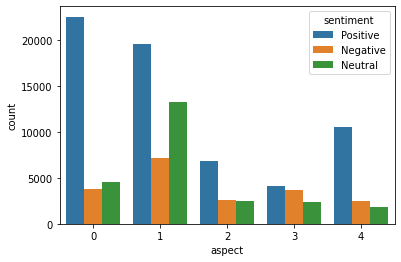

In [140]:
plot_sentiment_aspect(df_cs_final_aspect)
